# Analise de dados usando variáveis temporais

Nesse notebook vamos analisar dados utilizando variáveis temporais. 
Os dados são referentes a emprestimos realizados 

## Sobre os dados

O conjunto de dados é um registro de um instituto financeiro holandês, onde contém informações sobre emprestimos realizados entre os anos de 2016 até início de 2017.

## Visualização dos dados
### Carregando bibliotecas

In [53]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
from matplotlib import pyplot
from sklearn import tree
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, average_precision_score

###Lendo os Dados

In [54]:
raw_data = pd.read_csv('BPI_Challenge_2017.csv')
raw_data.columns.values

array(['Action', 'org:resource', 'concept:name', 'EventOrigin', 'EventID',
       'lifecycle:transition', 'time:timestamp', 'case:LoanGoal',
       'case:ApplicationType', 'case:concept:name',
       'case:RequestedAmount', 'FirstWithdrawalAmount', 'NumberOfTerms',
       'Accepted', 'MonthlyCost', 'Selected', 'CreditScore',
       'OfferedAmount', 'OfferID'], dtype=object)

###Corrigindo nomes das colunas

Algumas colunas vem com formatação complicada de entendimento, portanto essa açãos e faz necessária para melhor visualização.

In [55]:
fix_cols_names = lambda x: re.sub( '(?<!^)(?=[A-Z])', '_', x.replace('ID','Id')).lower().replace(':','_').replace('__','_')
fixed_app_cols = [fix_cols_names(col) for col in raw_data.columns]
raw_data.columns = fixed_app_cols

,action,org_resource,concept_name,event_origin,event_id,lifecycle_transition,time_timestamp,case_loan_goal,case_application_type,case_concept_name,case_requested_amount,first_withdrawal_amount,number_of_terms,accepted,monthly_cost,selected,credit_score,offered_amount,offer_id
0,Created,User_1,A_Create Application,Application,Application_652823628,complete,2016-01-01 09:51:15.304000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,statechange,User_1,A_Submitted,Application,ApplState_1582051990,complete,2016-01-01 09:51:15.352000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Created,User_1,W_Handle leads,Workflow,Workitem_1298499574,schedule,2016-01-01 09:51:15.774000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Deleted,User_1,W_Handle leads,Workflow,Workitem_1673366067,withdraw,2016-01-01 09:52:36.392000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Created,User_1,W_Complete application,Workflow,Workitem_1493664571,schedule,2016-01-01 09:52:36.403000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Criando colunas com dados temporáis

Foram criadas as colunas 

*   'datetime': transforma a coluna 'time_timestamp' para o formato de data
*   'month': indica o mês do registro
*   'week': indica a semana do registro





In [56]:
raw_data['datetime'] = pd.to_datetime(raw_data.time_timestamp)
raw_data['month'] = pd.DatetimeIndex(raw_data.datetime).month
raw_data['week'] = raw_data['datetime'].dt.strftime('%G%V')

Os dados ficaram assim com as novas colunas

In [57]:
raw_data

,action,org_resource,concept_name,event_origin,event_id,lifecycle_transition,time_timestamp,case_loan_goal,case_application_type,case_concept_name,case_requested_amount,first_withdrawal_amount,number_of_terms,accepted,monthly_cost,selected,credit_score,offered_amount,offer_id,datetime,month,week
0,Created,User_1,A_Create Application,Application,Application_652823628,complete,2016-01-01 09:51:15.304000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-01 09:51:15.304000+00:00,1,201553
1,statechange,User_1,A_Submitted,Application,ApplState_1582051990,complete,2016-01-01 09:51:15.352000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-01 09:51:15.352000+00:00,1,201553
2,Created,User_1,W_Handle leads,Workflow,Workitem_1298499574,schedule,2016-01-01 09:51:15.774000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-01 09:51:15.774000+00:00,1,201553
3,Deleted,User_1,W_Handle leads,Workflow,Workitem_1673366067,withdraw,2016-01-01 09:52:36.392000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-01 09:52:36.392000+00:00,1,201553
4,Created,User_1,W_Complete application,Workflow,Workitem_1493664571,schedule,2016-01-01 09:52:36.403000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-01 09:52:36.403000+00:00,1,201553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1202262,Deleted,User_1,W_Call after offers,Workflow,Workitem_1817549786,ate_abort,2017-01-06 06:33:02.212000+00:00,Home improvement,New credit,Application_1350494635,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-01-06 06:33:02.212000+00:00,1,201701
1202263,Created,User_1,W_Call after offers,Workflow,Workitem_363876066,schedule,2017-01-06 06:33:02.221000+00:00,Home improvement,New credit,Application_1350494635,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-01-06 06:33:02.221000+00:00,1,201701
1202264,statechange,User_28,A_Cancelled,Application,ApplState_1869071797,complete,2017-01-16 09:51:21.114000+00:00,Home improvement,New credit,Application_1350494635,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-01-16 09:51:21.114000+00:00,1,201703
1202265,statechange,User_28,O_Cancelled,Offer,OfferState_420066181,complete,2017-01-16 09:51:21.139000+00:00,Home improvement,New credit,Application_1350494635,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Offer_1580299144,2017-01-16 09:51:21.139000+00:00,1,201703


## Analise exploratória

Ao preparar os dados foram levantados os seguintes questionamentos:


1.   Em qual mês do ano ocorreu mais pedidos de emprestimos?
2.   De acordo com o objetivo do emprestimo, qual mês teve mais pedidos?
3.   Quantos dias em média demora para uma aplicação que foi aceita ser finalziada?



Para responder essas perguntas, primeiro vamos separar os dados apenas de criação de aplicação.

In [58]:
only_creation_data = raw_data[raw_data['concept_name'] == 'A_Create Application']
only_creation_data

,action,org_resource,concept_name,event_origin,event_id,lifecycle_transition,time_timestamp,case_loan_goal,case_application_type,case_concept_name,case_requested_amount,first_withdrawal_amount,number_of_terms,accepted,monthly_cost,selected,credit_score,offered_amount,offer_id,datetime,month,week
0,Created,User_1,A_Create Application,Application,Application_652823628,complete,2016-01-01 09:51:15.304000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-01 09:51:15.304000+00:00,1,201553
40,Created,User_1,A_Create Application,Application,Application_1691306052,complete,2016-01-01 10:16:11.500000+00:00,Home improvement,New credit,Application_1691306052,10000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-01 10:16:11.500000+00:00,1,201553
71,Created,User_1,A_Create Application,Application,Application_428409768,complete,2016-01-01 11:19:38.177000+00:00,Home improvement,New credit,Application_428409768,15000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-01 11:19:38.177000+00:00,1,201553
116,Created,User_1,A_Create Application,Application,Application_1746793196,complete,2016-01-01 12:34:53.911000+00:00,Car,New credit,Application_1746793196,5000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-01 12:34:53.911000+00:00,1,201553
200,Created,User_1,A_Create Application,Application,Application_828200680,complete,2016-01-01 13:00:04.360000+00:00,Home improvement,New credit,Application_828200680,35000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-01 13:00:04.360000+00:00,1,201553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1202068,Created,User_1,A_Create Application,Application,Application_1107993134,complete,2016-12-31 15:38:12.302000+00:00,Car,New credit,Application_1107993134,5000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-12-31 15:38:12.302000+00:00,12,201652
1202113,Created,User_1,A_Create Application,Application,Application_2103458006,complete,2016-12-31 16:40:45.514000+00:00,Existing loan takeover,New credit,Application_2103458006,15000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-12-31 16:40:45.514000+00:00,12,201652
1202136,Created,User_1,A_Create Application,Application,Application_59622033,complete,2016-12-31 16:43:28.509000+00:00,Home improvement,New credit,Application_59622033,10000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-12-31 16:43:28.509000+00:00,12,201652
1202193,Created,User_1,A_Create Application,Application,Application_303923658,complete,2016-12-31 16:59:16.240000+00:00,Car,New credit,Application_303923658,30000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-12-31 16:59:16.240000+00:00,12,201652


##Pergunta 1: Qual mês teve mais pedidos de emprestimo?

Como a coluna mês foi criada, para responder essa pergunta, agrupamos os dados de criação de aplicação pelo mês e tivemos o seguinte resultado.

In [59]:
creation_per_month = only_creation_data.month.value_counts().reset_index() \
                    .rename(index = str, columns = {'index':'month',
                                                    'month':'num_events'}) \
                    .sort_values('month') 
creation_per_month

,month,num_events
9,1,2194
7,2,2412
6,3,2454
10,4,2177
11,5,2068
3,6,3001
2,7,3039
0,8,3085
1,9,3042
4,10,2995


Como é possível ver na tabela acima, o mês que teve mais pedidos de emprestimos foi o mês 8 (Agosto).

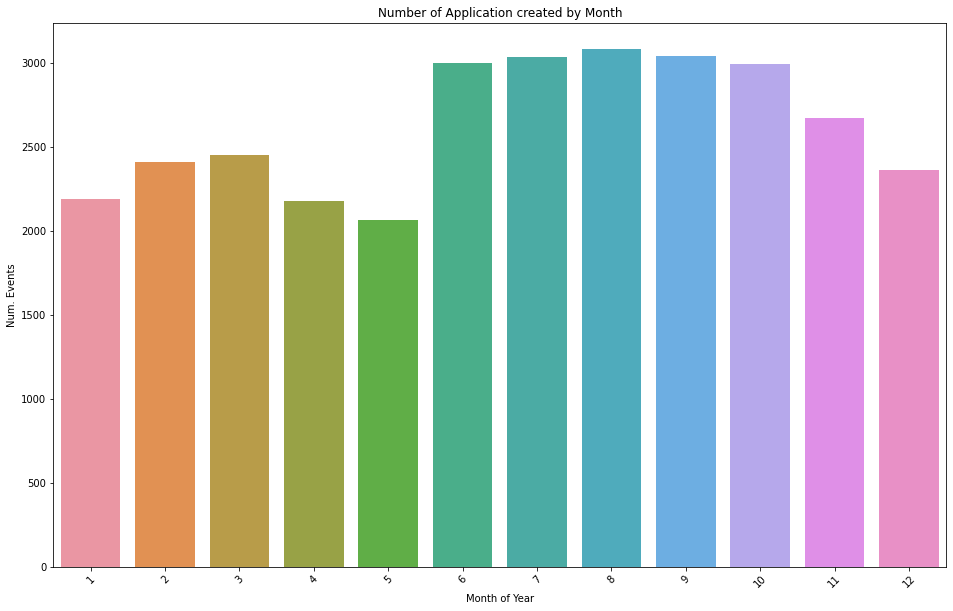

In [60]:
fig, ax = pyplot.subplots(figsize=(16,10))
g = sns.barplot(data = creation_per_month, x ='month', y= 'num_events');
g.set_xlabel('Month of Year')
g.set_ylabel('Num. Events')
g.set_title('Number of Application created by Month')
pyplot.xticks(rotation=45);

Pelo gráfico, vemos que os meses de Junho até Outubro tem quantidade de pedidos de emprestimos com valor próximo ao mês 8. Coincidencia ou não, é a época do verão na Europa.

##Pergunta 2: De acordo com o objetivo do emprestimo, qual mês teve mais pedidos?

Para responder essa pergunta, criamos uma nova tabela de dados, onde tem apenas o objetivo do emprestimo e o mês que foi pedido.

In [13]:
filtered_data = pd.DataFrame(only_creation_data,columns=['case_loan_goal',  'month'])
filtered_data.sample(10)

,case_loan_goal,month
477691,Car,6
451838,Existing loan takeover,6
636632,Extra spending limit,7
753613,Home improvement,8
167649,Home improvement,2
318275,Home improvement,4
1199136,Existing loan takeover,12
860068,Home improvement,9
514384,Remaining debt home,6
402438,Motorcycle,5


Com esses dados, agora criamos uma nova coluna onde temos a contagem de cada ocorrencia de objetivo por mês e depois filtramos deixando apenas a que for de maior valor.

In [14]:
grouped = filtered_data.groupby(['case_loan_goal', 'month']).size().sort_values(ascending=False).reset_index(name='count').drop_duplicates(subset='case_loan_goal')
grouped

,case_loan_goal,month,count
0,Car,8,865
4,Home improvement,10,826
19,Existing loan takeover,10,595
36,"Other, see explanation",8,321
38,Unknown,6,310
47,Not speficied,7,208
63,Remaining debt home,6,88
68,Extra spending limit,9,80
87,Caravan / Camper,8,55
95,Motorcycle,3,36


Com esses dados, é possível ver, para cada objetivo de emprestimo, qual o mês que houve maior ocorrencia de pedidos.

Text(0, 0.5, 'Total de Emprestimos solicitados')

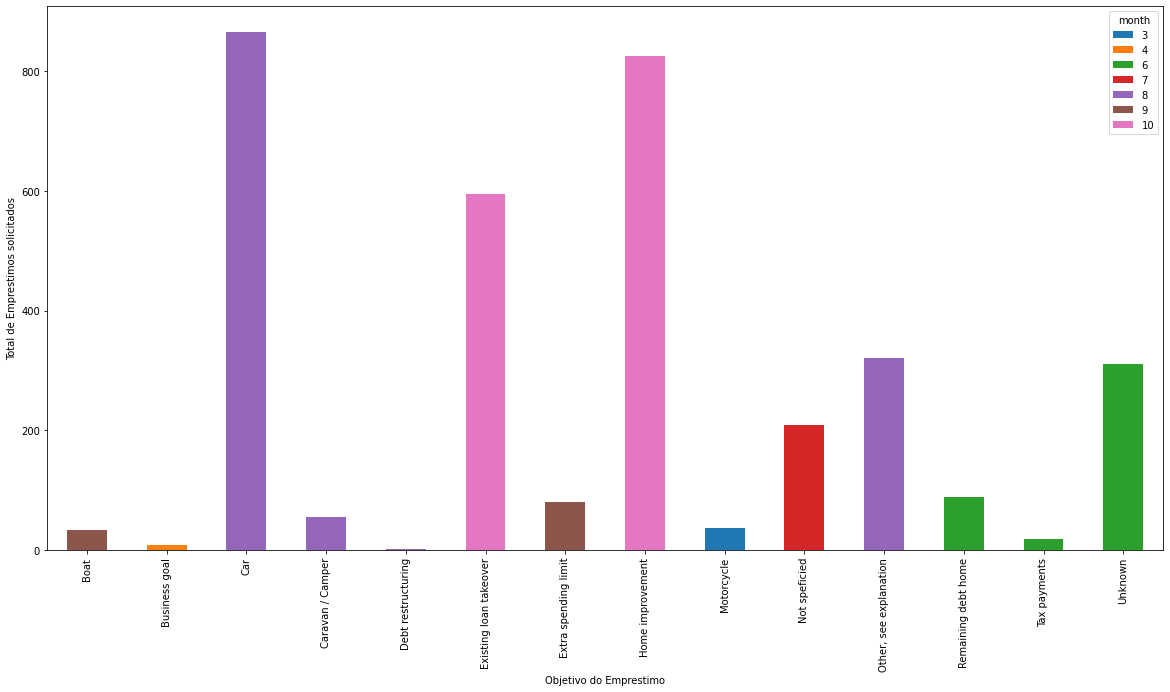

In [15]:
g = grouped.pivot_table(index='case_loan_goal', columns='month', values='count', aggfunc='sum', fill_value=0).plot.bar(stacked=True, figsize=(20,10))
g.set_xlabel('Objetivo do Emprestimo')
g.set_ylabel('Total de Emprestimos solicitados')

Visualizando o gráfico, podemos ver que alguns meses tiverem mais pedidos para mais de um objetivo. Por exemplo, no mês de agosto, foi onde ocorreram a maior quantidade de pedidos de emprestimo para Car, Caravan/Camper e Other. Assim como o mês de Junho, houver maior numero de pedidos para Remain Debit home, Tax Payments e Unknown.

## Pergunta 3: Quantos dias em média demora para uma aplicação que foi aceita ser finalziada?

Primeiro vou deixar apenas os dois estados no dataset, criação e finalização de aplicação, para poder realizar o calculo do tempo de duração.

In [16]:
only_app_data = raw_data[raw_data['event_origin'] == 'Application']
only_accepted_apps = only_app_data[(raw_data['concept_name'] == 'A_Create Application') | (raw_data['concept_name'] == 'A_Pending')]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [17]:
only_accepted_apps['concept_name'].value_counts()

A_Create Application    31509
A_Pending               17228
Name: concept_name, dtype: int64

Pela visualização da quantidade de cada uma, é possível ver que existe uma parte das aplicações que foram criadas que nao foram finalizadas com sucesso, portanto, vamos deixar apenas as que foram finalizadas com sucesso.

In [18]:
listOfAppFinished = only_accepted_apps[only_accepted_apps['concept_name'] == 'A_Pending']['case_concept_name'].tolist()
only_accepted_data = only_accepted_apps[only_accepted_apps['case_concept_name'].isin(listOfAppFinished)]

In [19]:
only_accepted_data

,action,org_resource,concept_name,event_origin,event_id,lifecycle_transition,time_timestamp,case_loan_goal,case_application_type,case_concept_name,case_requested_amount,first_withdrawal_amount,number_of_terms,accepted,monthly_cost,selected,credit_score,offered_amount,offer_id,datetime,month,week
0,Created,User_1,A_Create Application,Application,Application_652823628,complete,2016-01-01 09:51:15.304000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-01 09:51:15.304000+00:00,1,201553
38,statechange,User_115,A_Pending,Application,ApplState_1179730815,complete,2016-01-14 15:49:11.420000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-14 15:49:11.420000+00:00,1,201602
71,Created,User_1,A_Create Application,Application,Application_428409768,complete,2016-01-01 11:19:38.177000+00:00,Home improvement,New credit,Application_428409768,15000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-01 11:19:38.177000+00:00,1,201553
114,statechange,User_90,A_Pending,Application,ApplState_16917315,complete,2016-01-14 07:00:14.450000+00:00,Home improvement,New credit,Application_428409768,15000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-14 07:00:14.450000+00:00,1,201602
116,Created,User_1,A_Create Application,Application,Application_1746793196,complete,2016-01-01 12:34:53.911000+00:00,Car,New credit,Application_1746793196,5000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-01 12:34:53.911000+00:00,1,201553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1202111,statechange,User_83,A_Pending,Application,ApplState_407324650,complete,2017-01-23 07:06:27.167000+00:00,Car,New credit,Application_1107993134,5000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-01-23 07:06:27.167000+00:00,1,201704
1202136,Created,User_1,A_Create Application,Application,Application_59622033,complete,2016-12-31 16:43:28.509000+00:00,Home improvement,New credit,Application_59622033,10000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-12-31 16:43:28.509000+00:00,12,201652
1202191,statechange,User_30,A_Pending,Application,ApplState_356117270,complete,2017-01-23 07:44:22.568000+00:00,Home improvement,New credit,Application_59622033,10000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-01-23 07:44:22.568000+00:00,1,201704
1202193,Created,User_1,A_Create Application,Application,Application_303923658,complete,2016-12-31 16:59:16.240000+00:00,Car,New credit,Application_303923658,30000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-12-31 16:59:16.240000+00:00,12,201652


Agora vamos calcular o tempo que demorou desde a criação da aplicação, até seu estado de que foi finalizada com sucesso.

Esses dados vão ser colocados numa nova tabela de dados onde temos o nome da aplicação e a duração da mesma.

In [20]:
spent_data = only_accepted_data.groupby(by='case_concept_name')['datetime'].agg(lambda x: x.max() - x.min()).reset_index()
spent_data

,case_concept_name,datetime
0,Application_1000158214,8 days 00:47:34.434000
1,Application_1000339879,12 days 20:14:38.437000
2,Application_100034150,11 days 03:18:00.362000
3,Application_1000386745,10 days 23:27:27.917000
4,Application_1000474975,12 days 19:29:33.659000
...,...,...
17223,Application_999487618,11 days 17:48:43.692000
17224,Application_999507989,6 days 07:14:35.733000
17225,Application_999544538,79 days 18:48:35.266000
17226,Application_999993467,13 days 18:42:42.747000


Com o resultado em mãos, basta agora juntar esses dados com os dados gerais para ter o valor da duração de todas as aplicações que foram criadas com sucesso.

In [21]:
only_accepted_data = pd.merge(raw_data, spent_data, on='case_concept_name')
only_accepted_data

,action,org_resource,concept_name,event_origin,event_id,lifecycle_transition,time_timestamp,case_loan_goal,case_application_type,case_concept_name,case_requested_amount,first_withdrawal_amount,number_of_terms,accepted,monthly_cost,selected,credit_score,offered_amount,offer_id,datetime_x,month,week,datetime_y
0,Created,User_1,A_Create Application,Application,Application_652823628,complete,2016-01-01 09:51:15.304000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-01 09:51:15.304000+00:00,1,201553,13 days 05:57:56.116000
1,statechange,User_1,A_Submitted,Application,ApplState_1582051990,complete,2016-01-01 09:51:15.352000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-01 09:51:15.352000+00:00,1,201553,13 days 05:57:56.116000
2,Created,User_1,W_Handle leads,Workflow,Workitem_1298499574,schedule,2016-01-01 09:51:15.774000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-01 09:51:15.774000+00:00,1,201553,13 days 05:57:56.116000
3,Deleted,User_1,W_Handle leads,Workflow,Workitem_1673366067,withdraw,2016-01-01 09:52:36.392000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-01 09:52:36.392000+00:00,1,201553,13 days 05:57:56.116000
4,Created,User_1,W_Complete application,Workflow,Workitem_1493664571,schedule,2016-01-01 09:52:36.403000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-01 09:52:36.403000+00:00,1,201553,13 days 05:57:56.116000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
779163,statechange,User_28,A_Validating,Application,ApplState_1546255688,complete,2017-01-23 13:46:33.802000+00:00,Car,New credit,Application_303923658,30000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-01-23 13:46:33.802000+00:00,1,201704,22 days 22:13:51.950000
779164,Released,User_28,W_Validate application,Workflow,Workitem_943020709,suspend,2017-01-23 13:46:53.705000+00:00,Car,New credit,Application_303923658,30000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-01-23 13:46:53.705000+00:00,1,201704,22 days 22:13:51.950000
779165,statechange,User_29,O_Accepted,Offer,OfferState_507784570,complete,2017-01-23 15:13:08.185000+00:00,Car,New credit,Application_303923658,30000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Offer_1734870628,2017-01-23 15:13:08.185000+00:00,1,201704,22 days 22:13:51.950000
779166,statechange,User_29,A_Pending,Application,ApplState_769143185,complete,2017-01-23 15:13:08.190000+00:00,Car,New credit,Application_303923658,30000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-01-23 15:13:08.190000+00:00,1,201704,22 days 22:13:51.950000


Antes de continuar, organizamos um pouco os dados, renomeando a nova coluna e removendo outras que se mostraram desnecessárias.

In [22]:
only_accepted_data = only_accepted_data[only_accepted_data['case_concept_name'].isin(listOfAppFinished)]

In [23]:
only_accepted_data = only_accepted_data.drop(columns=['first_withdrawal_amount', 'number_of_terms','accepted','monthly_cost','selected','credit_score','offered_amount','offer_id', 'action', 'event_origin', 'event_id', 'lifecycle_transition', ])
only_accepted_data = only_accepted_data.rename(columns={"datetime_y": "spent_time"})
only_accepted_data

,org_resource,concept_name,time_timestamp,case_loan_goal,case_application_type,case_concept_name,case_requested_amount,datetime_x,month,week,spent_time
0,User_1,A_Create Application,2016-01-01 09:51:15.304000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,2016-01-01 09:51:15.304000+00:00,1,201553,13 days 05:57:56.116000
1,User_1,A_Submitted,2016-01-01 09:51:15.352000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,2016-01-01 09:51:15.352000+00:00,1,201553,13 days 05:57:56.116000
2,User_1,W_Handle leads,2016-01-01 09:51:15.774000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,2016-01-01 09:51:15.774000+00:00,1,201553,13 days 05:57:56.116000
3,User_1,W_Handle leads,2016-01-01 09:52:36.392000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,2016-01-01 09:52:36.392000+00:00,1,201553,13 days 05:57:56.116000
4,User_1,W_Complete application,2016-01-01 09:52:36.403000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,2016-01-01 09:52:36.403000+00:00,1,201553,13 days 05:57:56.116000
...,...,...,...,...,...,...,...,...,...,...,...
779163,User_28,A_Validating,2017-01-23 13:46:33.802000+00:00,Car,New credit,Application_303923658,30000.0,2017-01-23 13:46:33.802000+00:00,1,201704,22 days 22:13:51.950000
779164,User_28,W_Validate application,2017-01-23 13:46:53.705000+00:00,Car,New credit,Application_303923658,30000.0,2017-01-23 13:46:53.705000+00:00,1,201704,22 days 22:13:51.950000
779165,User_29,O_Accepted,2017-01-23 15:13:08.185000+00:00,Car,New credit,Application_303923658,30000.0,2017-01-23 15:13:08.185000+00:00,1,201704,22 days 22:13:51.950000
779166,User_29,A_Pending,2017-01-23 15:13:08.190000+00:00,Car,New credit,Application_303923658,30000.0,2017-01-23 15:13:08.190000+00:00,1,201704,22 days 22:13:51.950000


Então agora para responder nossa pergunta 3, basta analisar essa coluna nova.

In [24]:
only_accepted_data['spent_time'].describe()

count                      779168
mean      20 days 04:35:50.837805
std       13 days 05:55:56.484284
min        0 days 00:07:29.346000
25%       11 days 03:53:01.702000
50%       16 days 13:41:21.914000
75%       25 days 14:38:46.871000
max      145 days 21:54:09.869000
Name: spent_time, dtype: object

Como podemos ver, em média, uma aplicação que foi finalizada com sucesso, demora 20 dias, 4 horas e 36 minutos aproximadamento para ser finalizada.

O que chamou atenção, foi essa aplicação finalziada em 7 minutos, vamos puxar dados dela para ver se realmente aconteceu ou foi algum erro dos dados.

In [25]:
only_accepted_data[only_accepted_data['spent_time'] == '0 days 00:07:29.346000']

,org_resource,concept_name,time_timestamp,case_loan_goal,case_application_type,case_concept_name,case_requested_amount,datetime_x,month,week,spent_time
231820,User_30,A_Create Application,2016-05-02 09:37:02.254000+00:00,Unknown,Limit raise,Application_2072748824,0.0,2016-05-02 09:37:02.254000+00:00,5,201618,00:07:29.346000
231821,User_30,A_Concept,2016-05-02 09:37:02.257000+00:00,Unknown,Limit raise,Application_2072748824,0.0,2016-05-02 09:37:02.257000+00:00,5,201618,00:07:29.346000
231822,User_30,W_Complete application,2016-05-02 09:37:02.269000+00:00,Unknown,Limit raise,Application_2072748824,0.0,2016-05-02 09:37:02.269000+00:00,5,201618,00:07:29.346000
231823,User_30,W_Complete application,2016-05-02 09:37:02.274000+00:00,Unknown,Limit raise,Application_2072748824,0.0,2016-05-02 09:37:02.274000+00:00,5,201618,00:07:29.346000
231824,User_30,A_Accepted,2016-05-02 09:38:14.429000+00:00,Unknown,Limit raise,Application_2072748824,0.0,2016-05-02 09:38:14.429000+00:00,5,201618,00:07:29.346000
231825,User_30,O_Create Offer,2016-05-02 09:39:23.068000+00:00,Unknown,Limit raise,Application_2072748824,0.0,2016-05-02 09:39:23.068000+00:00,5,201618,00:07:29.346000
231826,User_30,O_Created,2016-05-02 09:39:24.337000+00:00,Unknown,Limit raise,Application_2072748824,0.0,2016-05-02 09:39:24.337000+00:00,5,201618,00:07:29.346000
231827,User_30,O_Sent (online only),2016-05-02 09:39:50.508000+00:00,Unknown,Limit raise,Application_2072748824,0.0,2016-05-02 09:39:50.508000+00:00,5,201618,00:07:29.346000
231828,User_30,W_Complete application,2016-05-02 09:39:50.522000+00:00,Unknown,Limit raise,Application_2072748824,0.0,2016-05-02 09:39:50.522000+00:00,5,201618,00:07:29.346000
231829,User_30,W_Call after offers,2016-05-02 09:39:50.529000+00:00,Unknown,Limit raise,Application_2072748824,0.0,2016-05-02 09:39:50.529000+00:00,5,201618,00:07:29.346000


Pelo que vemos, realmente ela foi rapidamente finalizada depois de aberta. Vale notar que o mesmo usuário que criou ela, foi o que deu continuidade a todo o processo ate o fim, provavelmente isso influenciou na rapidez.

#**CLASSIFICADORES**

Ao responder essa questão 3, foi levantada a seguinte questão. Será possível criar um classificador que prevê quanto tempo a aplicação será finalizada?

Para responder esta pergunta, começamos selecionando as features que ao meu ver são importantes para determinar.

In [38]:
copy_df = only_accepted_data[['case_loan_goal', 'case_application_type', 'month', 'week', 'org_resource',
                          'case_requested_amount', 'spent_time']].copy(deep=True)

Criando novas colunas para os tipos de objetivo e aplicação serem representados numericamente

In [39]:
encoder = OneHotEncoder()

encoded_df_loan_goal = pd.DataFrame(encoder.fit_transform(copy_df[['case_loan_goal']]).toarray())
encoded_df_loan_goal.columns = encoder.get_feature_names(['case_loan_goal'])


encoded_df_app_type = pd.DataFrame(encoder.fit_transform(copy_df[['case_application_type']]).toarray())
encoded_df_app_type.columns = encoder.get_feature_names(['case_application_type'])

copy_df.drop(['case_loan_goal', 'case_application_type'], axis = 1, inplace = True)

copy_df = pd.concat([copy_df, encoded_df_loan_goal, encoded_df_app_type], axis = 1)

copy_df.dropna(inplace=True)

Criando nova coluna onde o usuário que está trabalhando na aplicação possa ser representado numericamente

In [40]:
codes, uniques = pd.factorize(copy_df['org_resource'].values)
codes_df = pd.DataFrame(data=codes, columns=['org_resource_num'])
copy_df = pd.concat([copy_df, codes_df], axis = 1)

Alterando a coluna de tempo de duração para ser representado numericamente

In [41]:
date_num = pd.DataFrame(copy_df['spent_time'].dt.days.astype('int16'))
copy_df.drop(['spent_time'], axis = 1, inplace = True)
copy_df = pd.concat([copy_df, date_num], axis = 1)
copy_df.dropna(inplace=True)

In [42]:
copy_df

,month,week,org_resource,case_requested_amount,case_loan_goal_Boat,case_loan_goal_Business goal,case_loan_goal_Car,case_loan_goal_Caravan / Camper,case_loan_goal_Existing loan takeover,case_loan_goal_Extra spending limit,case_loan_goal_Home improvement,case_loan_goal_Motorcycle,case_loan_goal_Not speficied,"case_loan_goal_Other, see explanation",case_loan_goal_Remaining debt home,case_loan_goal_Tax payments,case_loan_goal_Unknown,case_application_type_Limit raise,case_application_type_New credit,org_resource_num,spent_time
0,1,201553,User_1,20000.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,13.0
1,1,201553,User_1,20000.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,13.0
2,1,201553,User_1,20000.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,13.0
3,1,201553,User_1,20000.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,13.0
4,1,201553,User_1,20000.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
779163,1,201704,User_28,30000.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,45,22.0
779164,1,201704,User_28,30000.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,45,22.0
779165,1,201704,User_29,30000.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,34,22.0
779166,1,201704,User_29,30000.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,34,22.0


Dividindo os dados em treino e teste.

In [43]:
x = copy_df[['month', 'week', 'case_requested_amount', 'org_resource_num',
             'case_loan_goal_Boat', 'case_loan_goal_Business goal', 'case_loan_goal_Car', 'case_loan_goal_Caravan / Camper',
             'case_loan_goal_Existing loan takeover', 'case_loan_goal_Extra spending limit', 'case_loan_goal_Home improvement',
             'case_loan_goal_Motorcycle', 'case_loan_goal_Not speficied', 'case_loan_goal_Other, see explanation',
             'case_loan_goal_Remaining debt home', 'case_loan_goal_Tax payments', 'case_loan_goal_Unknown',
             'case_application_type_Limit raise', 'case_application_type_New credit']].values

y = label_binarize(copy_df['spent_time'], classes=copy_df['spent_time'].unique())


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

Usando classificador de Arvore de Decisão com Regressão

In [44]:
tree_clf = tree.DecisionTreeRegressor()

tree_clf.fit(x_train,y_train)

y_pred=tree_clf.predict(x_test)

Resultado

In [45]:
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))
print('Average precision-recall score: {0:0.2f}'.format(average_precision_score(y_test, y_pred)))

Mean squared error: 0.00
Coefficient of determination: 0.74
Average precision-recall score: 0.86


Alterando a maneira de extrair o y para poder gerar o gráfico

In [47]:
y = copy_df['spent_time'].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [48]:
tree_clf = tree.DecisionTreeRegressor()

tree_clf.fit(x_train,y_train)

y_pred=tree_clf.predict(x_test)

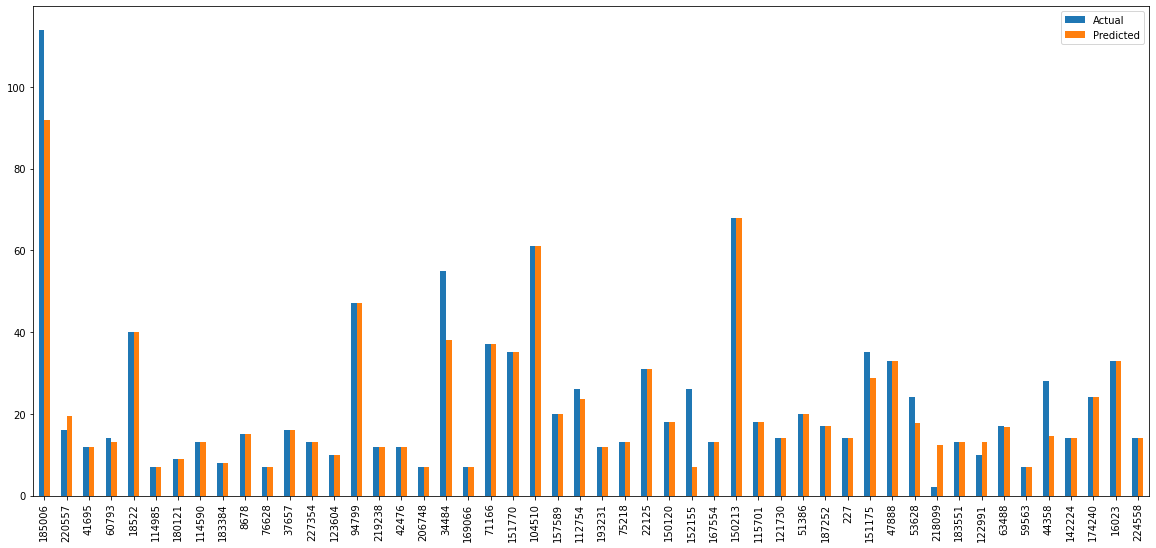

In [52]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df1 = df.sample(50)
df1.plot(kind='bar',figsize=(20,9))